In [1]:
import os
import re
import collections
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from random import sample

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/Dostoevskiy_IDIOT.txt', encoding="utf8") as input_file:
    lovecraft_text = input_file.read()
lovecraft_text = lovecraft_text.replace('\n', ' ' )

In [3]:
t_re = re.compile(r'[А-Я].*?[\.!?]', re.M)
handled_text = t_re.findall(lovecraft_text)
len(handled_text)

13734

In [4]:
MAX_LENGTH = 85

t_re = re.compile(r'[А-Я].*?[,]', re.M)

for i in range(len(handled_text)):
    handled_text[i] = ' ' + handled_text[i]
    if len(handled_text[i]) > MAX_LENGTH:
        end_word_index = MAX_LENGTH
        if handled_text[i][MAX_LENGTH - 1] != ' ':
            end_word_index = handled_text[i].find(' ', MAX_LENGTH - 1)
        handled_text[i] = handled_text[i][:end_word_index]

In [5]:
handled_text[:10]

[' В конце ноября, в оттепель, часов в девять утра, поезд Петербургско-Варшавской железной',
 ' Было так сыро и туманно, что насилу рассвело; в десяти шагах, вправо и влево от дороги,',
 ' Из пассажиров были и возвращавшиеся из-за границы; но более были наполнены отделения',
 ' Все, как водится, устали, у всех отяжелели за ночь глаза, все назяблись, все лица были',
 ' В одном из вагонов третьего класса, с рассвета, очутились друг против друга, у самого',
 ' Если б они оба знали один про другого, чем они особенно в эту минуту замечательны, то,',
 ' Один из них был небольшого роста, лет двадцати семи, курчавый и почти черноволосый, ',
 ' Нос его был широк и сплюснут, лицо скулистое; тонкие губы беспрерывно складывались в',
 ' Особенно приметна была в этом лице его мертвая бледность, придававшая всей физиономии',
 ' Он был тепло одет, в широкий, мерлушечий, черный, крытый тулуп, и за ночь не зяб, тогда']

In [6]:
#t_re = re.compile(r'([^\.!?]*[\.!?])', re.M)
#handled_text = t_re.findall(lovecraft_text)
#len(handled_text)

In [7]:
#all unique characters go here
tokens = list(set(''.join(handled_text)))

num_tokens = len(tokens)
print ('num_tokens =', num_tokens)

num_tokens = 127


In [8]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [9]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [10]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [11]:
print(handled_text[3])
print(to_matrix(handled_text[3:5], token_to_id)[0])
print(len(handled_text[3]))

 Все, как водится, устали, у всех отяжелели за ночь глаза, все назяблись, все лица были
[ 33  96  44  86  61  33 123  64 123  33  84 100  78   1   2  44  59  61
  33  53  44   2  64 118   1  61  33  53  33  84  44  86   0  33 100   2
  59 115  86 118  86 118   1  33 103  64  33  85 100  26  83  33  28 118
  64 103  64  61  33  84  44  86  33  85  64 103  59  72 118   1  44  83
  61  33  84  44  86  33 118   1  14  64  33  72 111 118   1]
87


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [13]:
from IPython.display import clear_output
from random import sample

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, hidden_size=512):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.LSTM = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h=None, c=None):
        if h is not None and c is not None:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x), (h, c))
        else:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x))
            
        next_logits = self.hid_to_logits(out_put)
        next_logp = F.log_softmax(next_logits, dim=-1)
        
        return next_logp, h_new, c_new

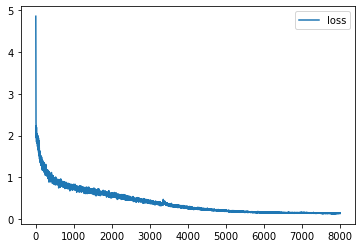

In [18]:
#here i started cell twice(that is why we got 8000 epochs here)
MAX_LENGTH = max(map(len, handled_text))

#model = CharLSTMLoop()
model = model.to(device)
#opt = torch.optim.Adam(model.parameters())
#history = []

#best_loss = 6

best_model_wts = copy.deepcopy(model.state_dict())

for i in range(4000):
    batch_ix = to_matrix(sample(handled_text, 128), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq, _, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    if loss < best_loss:
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 20 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [19]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [20]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    
    h_t = None
    c_t = None
    if len(seed_phrase) > 1:
        _, h_t, c_t = model.forward(x_sequence[:, :-1], h_t)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, h_t, c_t = model.forward(x_sequence[:, -1].unsqueeze(-1), h_t, c_t)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence[0].data.numpy()])


model = model.to('cpu')
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.5))

 А я думал, что уж сказал… Я одно такое письмецо получил, для передучить меня маленькую и тоскую      
 Он поворотил назад и прямо по дороге, по которой проходил вчера с Евлечением смотря                  
 Вы не отвечаете мне?                                                                                 
 Не стоите вы все ничего.                                                                             
 Если он сейчас не подойдет ко мне, не возьмет меня и не бросит тебя, то бери же его                  
 Ну, вот, вздор какой!                                                                                
 В последние десять или двадцать минут он говорил, разгорячившись, громко, нетерпеливою               
 Настасья Филипповна проходила в эту минуту мимо самых стульев барышень.                              
 Не могу же я получать эти письма!                                                                    
 В этом лице… страдания много… – проговорил князь, как бы невольно, как б

In [23]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.65))

 Но разъяснив вам, что меня не так-то легко прожить в положение делать.                               
 Право, всё это как-то нелепо и не может быть.                                                        
 Не было бы этого, я, может быть, никогда ему не усказала до считать, – вот к делу,                   
 Ну, уж теперь совсем довольно!                                                                       
 Тут один Тоцкий.                                                                                     
 Приличие и чинность чрезвычайные, несмотря на некоторый общий вид семейственности и                  
 Князь пригласил его садиться.                                                                        
 Почему она один вдруг встал с себя от удивленный вчерашней верлости, развернуть                      
 Лизавета Прокофьевна прямо направилась в сторону, противоположную той, в которую направлялись        
 Если бы вы пожили больше с людьми, а в свете, я надеюсь, вам будут рады,

In [26]:
torch.save(model, 'Doestoevsky.pt')